# RGB Color Extraction

| Channel	    | Meaning	        | Range     	    | Description                         |
| ------------- | ----------------- | ----------------- | ----------------------------------- |
| R	            | Red	            | 0–255	            | Intensity of red color component    |
| G 	        | Green	            | 0–255	            | Intensity of green color component  |
| B 	        | Blue  	        | 0–255	            | Intensity of blue color component   |

Processing: image_19439.jpg
RGB Dominant 1: [139.92755 158.53018 188.85913]
RGB Dominant 2: [222.94963 226.85403 235.93314]


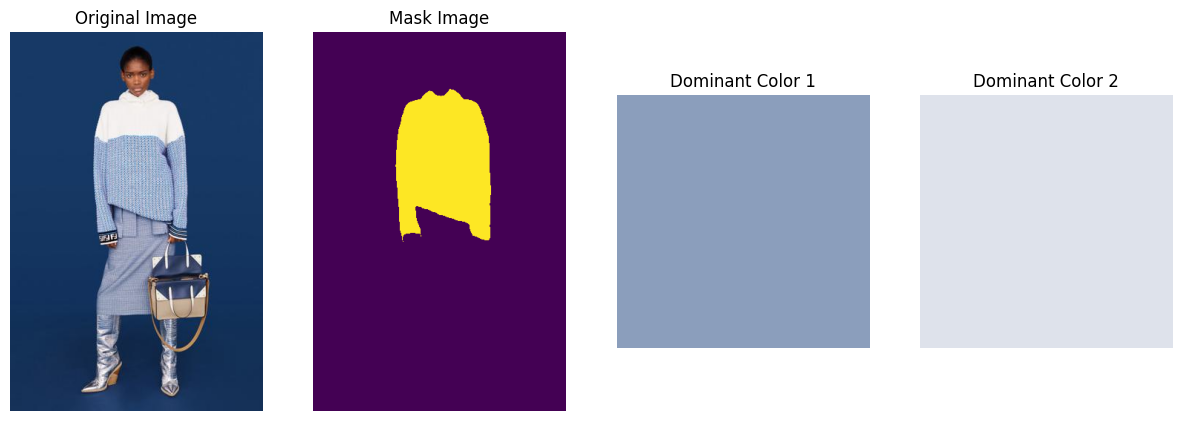

Processing: image_33946.jpg
RGB Dominant 1: [ 17.545673 117.83321  188.72133 ]
RGB Dominant 2: [ 33.797436  69.0298   124.08968 ]


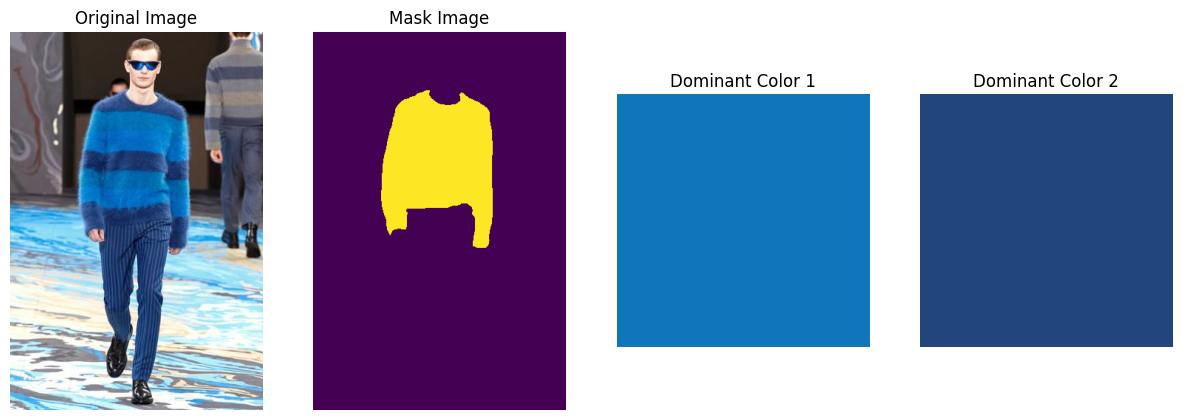

Processing: image_17606.jpg
RGB Dominant 1: [215.28294   20.068983  38.39689 ]
RGB Dominant 2: [132.09901   35.251682  27.833754]


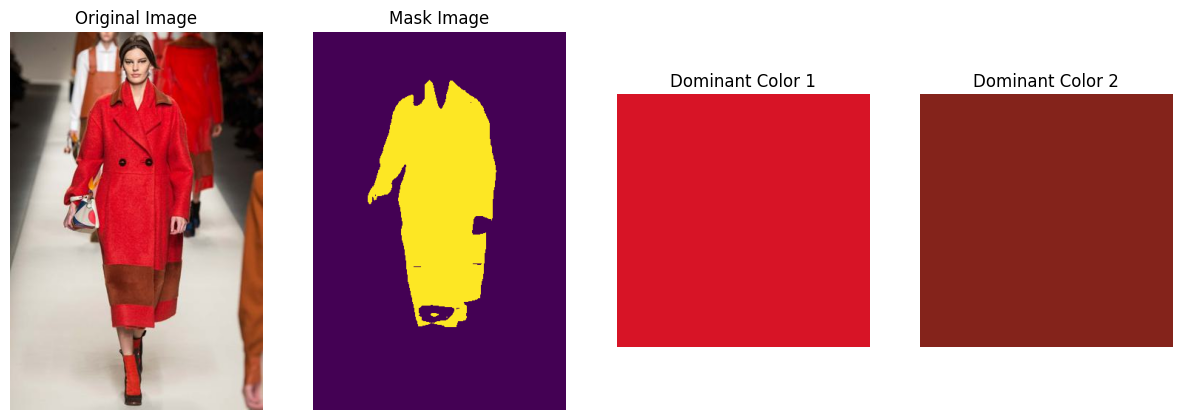


RGB values of two most dominant color saved to 'vogue-0-clothes-rgb.csv'.


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# Function to create a color bar (image filled with the specified RGB color)
def create_bar(height, width, color):
    bar = np.zeros((height, width, 3), np.uint8)  # Create a black bar
    bar[:] = color  # Fill the bar with the specified color
    red, green, blue = int(color[0]), int(color[1]), int(color[2])
    return bar, (red, green, blue)  # Return the bar and its RGB tuple

# Function to process an image and extract two dominant RGB colors using a mask
def process_image_with_mask(img, mask):
    # Convert PIL images to NumPy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Convert mask to binary: 1 for non-zero values (foreground), 0 otherwise
    mask_binary = (mask_array > 0).astype(np.uint8)

    # Extract pixels within the masked region
    segmented_pixels = img_array[mask_binary == 1]

    # If no pixels are found (e.g., empty mask), return default black colors
    if segmented_pixels.size == 0:
        return [[0, 0, 0], [0, 0, 0]]

    # Convert the pixel data to float32 for k-means clustering
    data = np.float32(segmented_pixels)

    # Set clustering parameters
    number_clusters = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply k-means clustering to find dominant colors
    _, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

    # Count pixels in each cluster
    unique, counts = np.unique(labels, return_counts=True)

    # Sort clusters by pixel count (most dominant first)
    sorted_clusters = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)

    # Retrieve the RGB values of the top 2 dominant clusters
    dominant_colors = []
    for i in range(2):
        dominant_index = sorted_clusters[i][0]
        dominant_color = centers[dominant_index]
        dominant_colors.append(dominant_color)

    return dominant_colors

# Function to safely return and round color value
def safe_get(color, index):
    return int(round(color[index])) if index < len(color) else 999  # Return 999 if color value doesn't exist

# Define input and mask image directories
input_directory = 'vogue-0'
mask_directory = 'vogue-0-clothes-mask'

# Store all RGB results
dominant_rgb_data = []

# Check if directories exist
if not os.path.exists(input_directory) or not os.path.exists(mask_directory):
    print("Input or mask directory not found.")
else:
    # List all image files (JPEG only)
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith((".jpg", ".jpeg"))]

    # Process each image without tqdm
    for filename in image_files:
        print(f"Processing: {filename}")
        base_name = os.path.splitext(filename)[0]
        image_path = os.path.join(input_directory, filename)
        mask_path = os.path.join(mask_directory, base_name + ".png")

        # Skip if corresponding mask is not found
        if not os.path.exists(mask_path):
            print(f"Mask not found for {filename}, skipping.")
            continue

        # Load the image and mask
        pil_image = Image.open(image_path).convert("RGB")
        mask_image = Image.open(mask_path).convert("L")  # Load mask as grayscale

        # Extract two dominant RGB colors
        dominant_colors = process_image_with_mask(pil_image, mask_image)

        # Store RGB values into the list
        dominant_rgb_data.append({
            'file_name': filename,
            'r1': safe_get(dominant_colors[0], 0),
            'g1': safe_get(dominant_colors[0], 1),
            'b1': safe_get(dominant_colors[0], 2),
            'r2': safe_get(dominant_colors[1], 0) if len(dominant_colors) > 1 else 999,
            'g2': safe_get(dominant_colors[1], 1) if len(dominant_colors) > 1 else 999,
            'b2': safe_get(dominant_colors[1], 2) if len(dominant_colors) > 1 else 999
        })

        # Generate color bars for visualization
        bars = []
        for color in dominant_colors:
            bar, rgb = create_bar(200, 200, color)
            bars.append(bar)

        # Plot the original image, mask, and color bars
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(np.array(pil_image))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(np.array(mask_image))
        plt.title('Mask Image')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(bars[0])
        plt.title('Dominant Color 1')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(bars[1])
        plt.title('Dominant Color 2')
        plt.axis('off')

        # Print RGB values to console
        print(f'RGB Dominant 1: {dominant_colors[0]}')
        print(f'RGB Dominant 2: {dominant_colors[1]}')

        # Show the plot
        plt.show()

# Convert all collected data into a DataFrame and save to CSV
dominant_rgb_df = pd.DataFrame(dominant_rgb_data)
csv_file_path = 'vogue-0-clothes-rgb.csv'
dominant_rgb_df.to_csv(csv_file_path, index=False)

# Notify the user
print(f"\nRGB values of two most dominant color saved to '{csv_file_path}'.")

Processing: image_21101.jpg
RGB Dominant 1: [181.34491 105.27296  66.74938]
RGB Dominant 2: [114.54608   53.81765   27.141178]


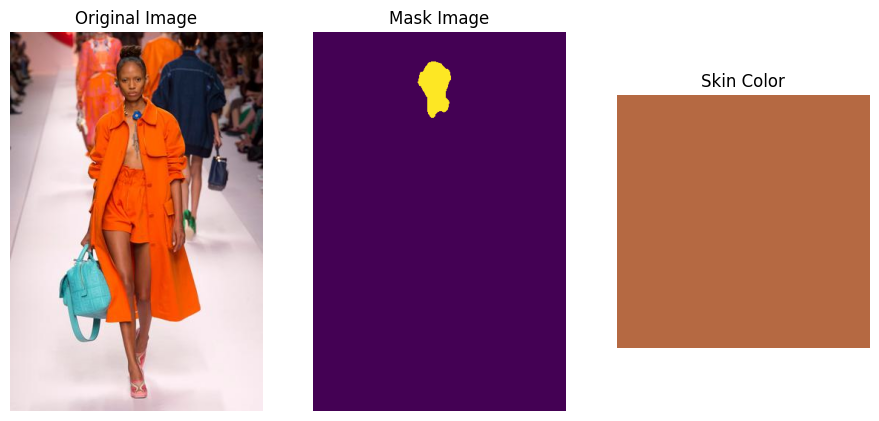

Processing: image_55209.jpg
RGB Dominant 1: [230.26025 189.86987 188.11511]
RGB Dominant 2: [128.59314   99.55882   94.312096]


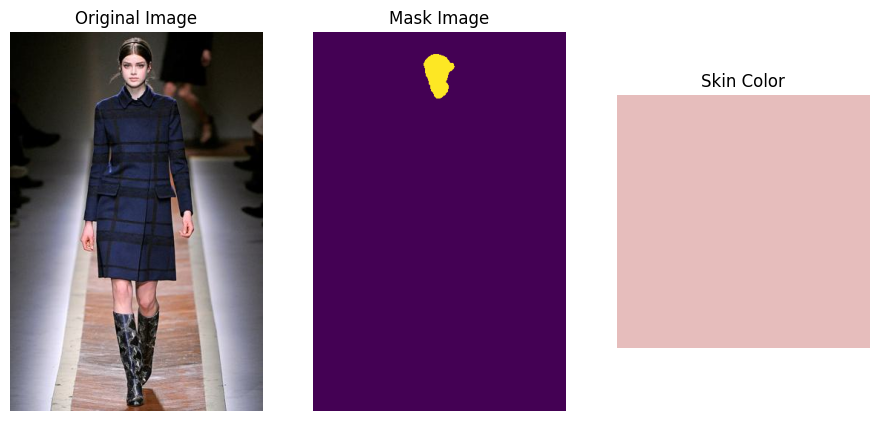

Processing: image_20944.jpg
RGB Dominant 1: [54.9812   32.268982 21.141722]
RGB Dominant 2: [130.69643  98.33418  86.38776]


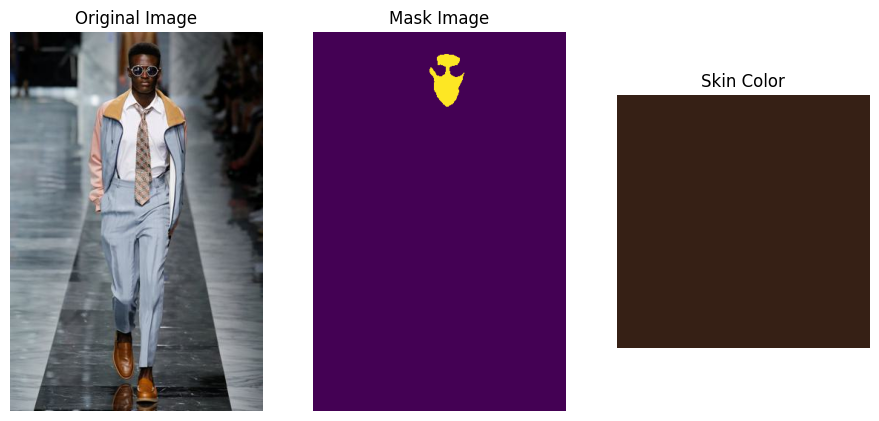


RGB values of two most dominant color saved to 'vogue-0-clothes-rgb.csv'.


In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# Function to create a color bar (image filled with the specified RGB color)
def create_bar(height, width, color):
    bar = np.zeros((height, width, 3), np.uint8)  # Create a black bar
    bar[:] = color  # Fill the bar with the specified color
    red, green, blue = int(color[0]), int(color[1]), int(color[2])
    return bar, (red, green, blue)  # Return the bar and its RGB tuple

# Function to process an image and extract two dominant RGB colors using a mask
def process_image_with_mask(img, mask):
    # Convert PIL images to NumPy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Convert mask to binary: 1 for non-zero values (foreground), 0 otherwise
    mask_binary = (mask_array > 0).astype(np.uint8)

    # Extract pixels within the masked region
    segmented_pixels = img_array[mask_binary == 1]

    # If no pixels are found (e.g., empty mask), return default black colors
    if segmented_pixels.size == 0:
        return [[0, 0, 0], [0, 0, 0]]

    # Convert the pixel data to float32 for k-means clustering
    data = np.float32(segmented_pixels)

    # Set clustering parameters
    number_clusters = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply k-means clustering to find dominant colors
    _, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

    # Count pixels in each cluster
    unique, counts = np.unique(labels, return_counts=True)

    # Sort clusters by pixel count (most dominant first)
    sorted_clusters = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)

    # Retrieve the RGB values of the top 2 dominant clusters
    dominant_colors = []
    for i in range(2):
        dominant_index = sorted_clusters[i][0]
        dominant_color = centers[dominant_index]
        dominant_colors.append(dominant_color)

    return dominant_colors

# Function to safely return and round color value
def safe_get(color, index):
    return int(round(color[index])) if index < len(color) else 999  # Return 999 if color value doesn't exist

# Define input and mask image directories
input_directory = 'vogue-1'
mask_directory = 'vogue-1-face-mask'

# Store all RGB results
dominant_rgb_data = []

# Check if directories exist
if not os.path.exists(input_directory) or not os.path.exists(mask_directory):
    print("Input or mask directory not found.")
else:
    # List all image files (JPEG only)
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith((".jpg", ".jpeg"))]

    # Process each image without tqdm
    for filename in image_files:
        print(f"Processing: {filename}")
        base_name = os.path.splitext(filename)[0]
        image_path = os.path.join(input_directory, filename)
        mask_path = os.path.join(mask_directory, base_name + ".png")

        # Skip if corresponding mask is not found
        if not os.path.exists(mask_path):
            print(f"Mask not found for {filename}, skipping.")
            continue

        # Load the image and mask
        pil_image = Image.open(image_path).convert("RGB")
        mask_image = Image.open(mask_path).convert("L")  # Load mask as grayscale

        # Extract two dominant RGB colors
        dominant_colors = process_image_with_mask(pil_image, mask_image)

        # Store RGB values into the list
        dominant_rgb_data.append({
            'file_name': filename,
            'r1': safe_get(dominant_colors[0], 0),
            'g1': safe_get(dominant_colors[0], 1),
            'b1': safe_get(dominant_colors[0], 2),
            'r2': safe_get(dominant_colors[1], 0) if len(dominant_colors) > 1 else 999,
            'g2': safe_get(dominant_colors[1], 1) if len(dominant_colors) > 1 else 999,
            'b2': safe_get(dominant_colors[1], 2) if len(dominant_colors) > 1 else 999
        })

        # Generate color bars for visualization
        bars = []
        for color in dominant_colors:
            bar, rgb = create_bar(200, 200, color)
            bars.append(bar)

        # Plot the original image, mask, and color bars
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.imshow(np.array(pil_image))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(np.array(mask_image))
        plt.title('Mask Image')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(bars[0])
        plt.title('Skin Color')
        plt.axis('off')

        # plt.subplot(1, 4, 4)
        # plt.imshow(bars[1])
        # plt.title('Dominant Color 2')
        # plt.axis('off')

        # Print RGB values to console
        print(f'RGB Dominant 1: {dominant_colors[0]}')
        print(f'RGB Dominant 2: {dominant_colors[1]}')

        # Show the plot
        plt.show()

# Convert all collected data into a DataFrame and save to CSV
dominant_rgb_df = pd.DataFrame(dominant_rgb_data)
csv_file_path = 'vogue-0-clothes-rgb.csv'
dominant_rgb_df.to_csv(csv_file_path, index=False)

# Notify the user
print(f"\nRGB values of two most dominant color saved to '{csv_file_path}'.")

In [2]:
import numpy as np
from PIL import Image
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Function to process an image using its corresponding mask
def process_image_with_mask(img, mask):
    # Convert PIL images to NumPy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Convert mask to binary (1 for mask area, 0 otherwise)
    mask_binary = (mask_array > 0).astype(np.uint8)

    # Extract only the pixels within the masked region
    segmented_pixels = img_array[mask_binary == 1]

    # If the mask doesn't cover any pixels, return default black colors
    if segmented_pixels.size == 0:
        return [[0, 0, 0], [0, 0, 0]]

    # Convert pixel data to float32 for k-means clustering
    data = np.float32(segmented_pixels)

    # Define parameters for k-means clustering
    number_clusters = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # Apply k-means to find 2 dominant color clusters
    compactness, labels, centers = cv2.kmeans(data, number_clusters, None, criteria, 10, flags)

    # Count the number of pixels in each cluster
    unique, counts = np.unique(labels, return_counts=True)

    # Sort clusters by number of pixels in descending order
    sorted_clusters = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)

    # Get the RGB values of the two most dominant clusters
    dominant_colors = []
    for i in range(2):
        dominant_index = sorted_clusters[i][0]
        dominant_color = centers[dominant_index]
        dominant_colors.append(dominant_color)

    return dominant_colors

# Function to safely return and round color value
def safe_get(color, index):
    return int(round(color[index])) if index < len(color) else 999  # Return 999 if color value doesn't exist

# Define input directories
input_directory = 'vogue-4'        # Directory containing images
mask_directory = 'vogue-4-face-mask'         # Directory containing corresponding masks

# List to store RGB values for each image
dominant_rgb_data = []

# Check if both directories exist
if not os.path.exists(input_directory) or not os.path.exists(mask_directory):
    print("Input or mask directory not found.")
else:
    # Get all image files (JPG or JPEG) from input directory
    image_files = [f for f in os.listdir(input_directory) if f.lower().endswith((".jpg", ".jpeg"))]

    # Process each image with its corresponding mask
    for filename in tqdm(image_files, desc="Processing images with mask"):
        base_name = os.path.splitext(filename)[0]  # Get filename without extension
        image_path = os.path.join(input_directory, filename)
        mask_path = os.path.join(mask_directory, base_name + ".png")

        # Skip if mask doesn't exist
        if not os.path.exists(mask_path):
            print(f"Mask not found for {filename}, skipping.")
            continue

        # Load and convert image to RGB, mask to grayscale
        pil_image = Image.open(image_path).convert("RGB")
        mask_image = Image.open(mask_path).convert("L")

        # Get two dominant RGB colors from masked image region
        dominant_colors = process_image_with_mask(pil_image, mask_image)

        # Store RGB values into the list
        dominant_rgb_data.append({
            'file_name': filename,
            'r1': safe_get(dominant_colors[0], 0),
            'g1': safe_get(dominant_colors[0], 1),
            'b1': safe_get(dominant_colors[0], 2),
            'r2': safe_get(dominant_colors[1], 0) if len(dominant_colors) > 1 else 999,
            'g2': safe_get(dominant_colors[1], 1) if len(dominant_colors) > 1 else 999,
            'b2': safe_get(dominant_colors[1], 2) if len(dominant_colors) > 1 else 999
        })

        # Store RGB values into the list
        # dominant_rgb_data.append({
        #     'file_name': filename,
        #     'r1': dominant_colors[0][0],
        #     'g1': dominant_colors[0][1],
        #     'b1': dominant_colors[0][2],
        #     'r2': dominant_colors[1][0],
        #     'g2': dominant_colors[1][1],
        #     'b2': dominant_colors[1][2]
        # })

# Convert the list of RGB data into a DataFrame
dominant_rgb_df = pd.DataFrame(dominant_rgb_data)

# Save the DataFrame to a CSV file
csv_file_path = 'vogue-4-face-rgb.csv'
dominant_rgb_df.to_csv(csv_file_path, index=False)

# Notify user of success
print(f"\nRGB values of two most dominant color saved to '{csv_file_path}'.")


Input or mask directory not found.

RGB values of two most dominant color saved to 'vogue-4-face-rgb.csv'.


Clean CSV Data

- Remove unused column (second dominant color)
- Rename r1, g1, b1 column
- Sort based on file name

In [ ]:
import pandas as pd

# === Load your CSV ===
csv_file = 'vogue-clothes-rgb.csv'        # Replace with your actual file name
df = pd.read_csv(csv_file)

# === Drop r2, g2, b2 ===
df = df.drop(columns=['r2', 'g2', 'b2'])

# === Rename columns ===
df = df.rename(columns={
    'r1': 'r_value',
    'g1': 'g_value',
    'b1': 'b_value'
})

# === Sort by file_name ===
df = df.sort_values(by='file_name')

# === Save to new CSV ===
df.to_csv('cleaned-vogue-clothes-rgb.csv', index=False)

print("Cleaned CSV saved as '-cleaned-vogue-clothes-rgb.csv'")


Cleaned CSV saved as '-cleaned-vogue-clothes-rgb.csv'


In [ ]:
import pandas as pd

# === Load your CSV ===
csv_file = 'vogue-face-rgb.csv'        # Replace with your actual file name
df = pd.read_csv(csv_file)

# === Drop r2, g2, b2 ===
df = df.drop(columns=['r2', 'g2', 'b2'])

# === Rename columns ===
df = df.rename(columns={
    'r1': 'r_value',
    'g1': 'g_value',
    'b1': 'b_value'
})

# === Sort by file_name ===
df = df.sort_values(by='file_name')

# === Save to new CSV ===
df.to_csv('cleaned-vogue-face-rgb.csv', index=False)

print("Cleaned CSV saved as '-cleaned-vogue-face-rgb.csv'")


Cleaned CSV saved as '-cleaned-vogue-face-rgb.csv'


Remove failed color extraction

In [ ]:
files_to_remove = ['image_50841.jpg', 'image_25908.jpg', 'image_49867.jpg', 'image_49883.jpg', 'image_50713.jpg', 'image_51267.jpg']

df = df[~df['file_name'].isin(files_to_remove)].reset_index(drop=True)